<a href="https://colab.research.google.com/github/pumazzo/ML4HS-UC/blob/main/Notebook_5_ML4HS_UC2023_Regularization_for_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Build a dummy dataset
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [2]:
# Set random seed for reproducibility
np.random.seed(123)
torch.manual_seed(123)

def generate_dataset(N, D, num_samples, W):
    # Generate correlated variables
    covariance_matrix = 0.7*np.random.randn(N, N)
    diagonal_values = np.ones(N)
    np.fill_diagonal(covariance_matrix, diagonal_values)
    covariance_matrix = 0.5*np.dot(covariance_matrix, covariance_matrix.T)

    # Ensure positive definiteness using Cholesky decomposition
    L = np.linalg.cholesky(covariance_matrix)
    covariance_matrix = np.dot(L, L.T)

    X = np.random.multivariate_normal(np.zeros(N), covariance_matrix, num_samples)

    # Take correlated variables with target
    correlated_vars = X[:,:D]

    # take  uncorrelated variables
    uncorrelated_vars = X[:,D:]



    # Generate target weigths variable y
    weights = np.expand_dims(np.array(W),axis=1)

    # Generate target variable y as a weighted sum of correlated variables
    y = np.dot(correlated_vars, weights) + 0.15*np.random.randn(num_samples, 1)


    # Combine correlated and uncorrelated variables
    X = np.concatenate((correlated_vars, uncorrelated_vars), axis=1)

    # Print correlation between correlated variables and y
    correlations = np.corrcoef(np.concatenate((X, y), axis=1), rowvar=False)
    corr_with_y = correlations[:-1, -1]
    print("Correlation between correlated variables and y:")
    print(corr_with_y)

    y = y.squeeze()


    return X, y,covariance_matrix

# Parameters
N = 15  # Number of total variables
D = 2   # Number of correlated variables
num_samples = 256

# Generate dataset
weights = [0.2,-0.2]
X, y,covariance_matrix = generate_dataset(N, D, num_samples,weights)

Correlation between correlated variables and y:
[ 0.64694298 -0.73188423 -0.05048765  0.0677833   0.10387072  0.22961525
  0.08496115  0.08698447 -0.33216695 -0.05775758  0.34784588 -0.16368191
  0.09877331 -0.15050175  0.22045055]


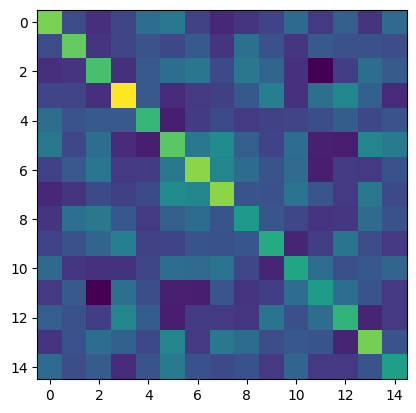

In [3]:
plt.figure()
plt.imshow(covariance_matrix)

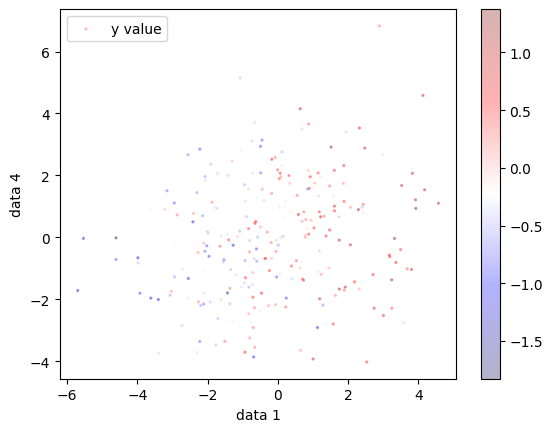

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X[:,0],X[:,4],c=y,s=2,alpha =0.3,cmap="seismic",label = "y value")
plt.xlabel("data 1")
plt.ylabel("data 4")
plt.legend()
plt.colorbar()

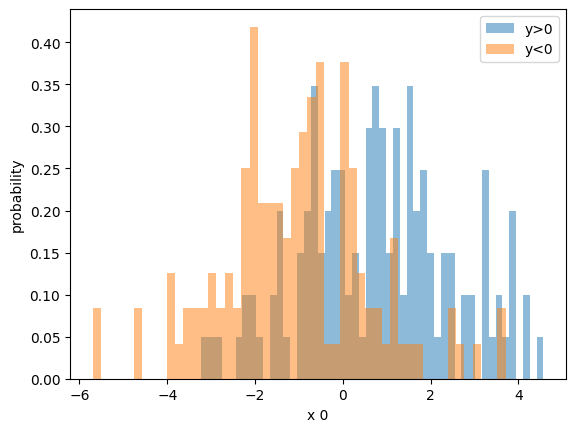

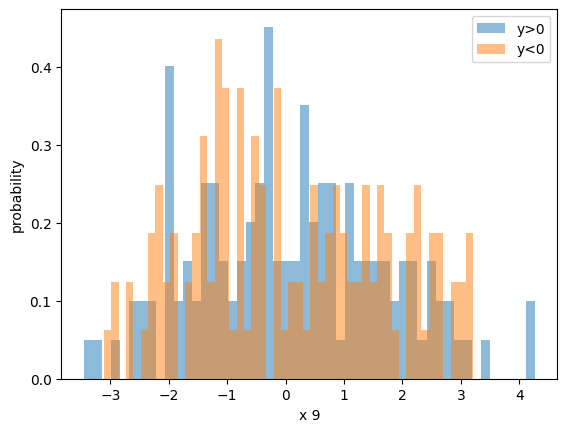

In [5]:
plt.figure()
plt.hist(X[(y>0),0],50,alpha =0.5,density=True,label="y>0")
plt.hist(X[(y<0),0],50,alpha =0.5,density=True,label="y<0")
plt.xlabel("x 0")
plt.ylabel("probability")
plt.legend()


plt.figure()
plt.hist(X[(y>0),9],50,alpha =0.5,density=True,label="y>0")
plt.hist(X[(y<0),9],50,alpha =0.5,density=True,label="y<0")
plt.xlabel("x 9")
plt.ylabel("probability")
plt.legend()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train).float()

# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)


    def forward(self, x):
        out = self.linear(x)

        return out



# Define the loss function and optimizer
def train_model(model, X_train, y_train):#TODO: add regularization L1
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.05)

  losses = []
  MAEs = []
  #store regularization also



  # Training loop
  num_epochs = 250
  for epoch in range(num_epochs):
      # Forward pass
      outputs = model(X_tensor)
      #reg here
      loss = criterion(outputs.squeeze(), y_tensor)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute MAE
      mae = torch.abs(outputs.squeeze()- y_tensor).mean()

      # Append results to lists
      losses.append(loss.item())
      MAEs.append(mae.item())


      # Print progress
      if (epoch + 1) % 20 == 0:
          print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

  # Print the model's parameters
  print("Model parameters:")
  for name, param in model.named_parameters():
      if param.requires_grad:
          print(name, param.data)

  return model,losses,MAEs




Epoch [20/250], Loss: 0.0636930763721466
Epoch [40/250], Loss: 0.023677412420511246
Epoch [60/250], Loss: 0.018962936475872993
Epoch [80/250], Loss: 0.018769193440675735
Epoch [100/250], Loss: 0.018652427941560745
Epoch [120/250], Loss: 0.018645942211151123
Epoch [140/250], Loss: 0.01864488795399666
Epoch [160/250], Loss: 0.01864469237625599
Epoch [180/250], Loss: 0.018644580617547035
Epoch [200/250], Loss: 0.01864447072148323
Epoch [220/250], Loss: 0.018644357100129128
Epoch [240/250], Loss: 0.018644241616129875
Model parameters:
linear.weight tensor([[ 0.3149, -0.1545,  0.1466,  0.0395, -0.0706, -0.1228, -0.0019,  0.0992,
         -0.0346,  0.0151,  0.0044,  0.0993, -0.0616, -0.0053,  0.0675]])
linear.bias tensor([-0.0016])


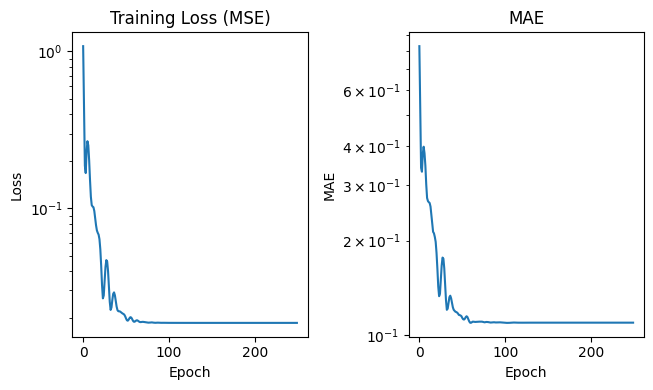

In [10]:

# Instantiate the logistic regression model

model = LogisticRegression(N)
model,losses,MAEs = train_model(model, X_train, y_train)#
# Plot the results
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (MSE)')
plt.yscale('log')

plt.subplot(1, 3, 2)
plt.plot(MAEs)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE')
plt.yscale('log')

#plt.subplot(1, 3, 3)
#plt.plot(regs)
#plt.xlabel('Epoch')
#plt.ylabel('|W|')
#plt.title('L1')




plt.tight_layout()
plt.show()

In [11]:
model.eval()
with torch.no_grad():
  pred = model(torch.from_numpy(X_test).float()).detach().numpy().squeeze()



Text(0.5, 1.0, 'Predicted vs True (Test)')

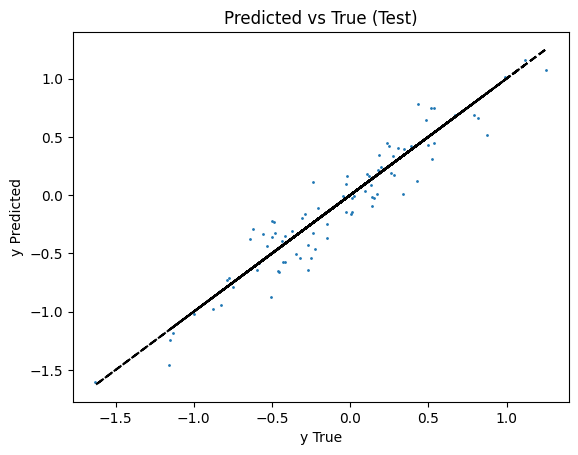

In [12]:
plt.figure()
plt.scatter(y_test,pred,s =1)
plt.plot(y_test,y_test,c="k",linestyle="--")
plt.xlabel('y True')
plt.ylabel('y Predicted')
plt.title('Predicted vs True (Test)')



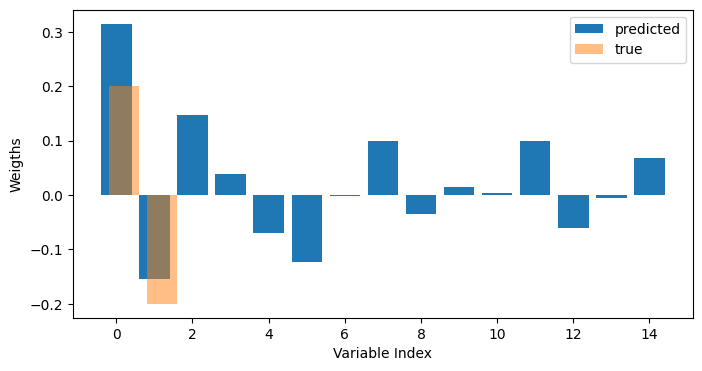

In [13]:
pred_weights = model.linear.weight.detach().numpy().squeeze()
plt.figure(figsize=(8, 4))
plt.bar(range(N), pred_weights,label="predicted")
plt.bar(np.arange(D)+0.2, weights,alpha=0.5,label="true")
plt.xlabel("Variable Index")
plt.ylabel("Weigths")
plt.legend()